# IGRF VADM variability 

This notebook calculates the implied virtual axial dipole moment from the IGRF field model in order to visualize variability that would be implied by global sampling in the present day.

In [1]:
import math
import datetime
from typing import List, Tuple
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def today_decimal_year() -> float:
    """Calculate today's date in decimal year format.

    Parameters:
        None

    Returns:
        float: Today's date as a decimal year.
    """
    today = datetime.date.today()
    year_start = datetime.date(today.year, 1, 1)
    year_end = datetime.date(today.year + 1, 1, 1)
    year_elapsed = (today - year_start).days
    year_duration = (year_end - year_start).days
    return today.year + year_elapsed / year_duration

def generate_fibonacci_sphere_points(n_points: int) -> List[Tuple[float, float]]:
    """Generate evenly distributed (longitude, latitude) points on a sphere using the Fibonacci
    sphere algorithm.

    Parameters:
        n_points (int): The number of points to generate.

    Returns:
        List[Tuple[float, float]]:
            A list of tuples where each tuple contains the longitude and latitude in degrees.
    """
    points = []
    golden_angle = math.pi * (3 - math.sqrt(5))
    for i in range(n_points):
        # y goes from 1 to -1
        y = 1 - (i / float(n_points - 1)) * 2
        radius = math.sqrt(1 - y * y)
        theta = golden_angle * i
        x = math.cos(theta) * radius
        z = math.sin(theta) * radius
        # Convert Cartesian to spherical coordinates
        lat = math.degrees(math.asin(y))
        lon = math.degrees(math.atan2(z, x))
        if lon < 0:
            lon += 360
        points.append((lon, lat))
    return points


In [3]:
num_points = 100  # number of evenly distributed points
points = generate_fibonacci_sphere_points(num_points)

lons, lats = zip(*points)  # This unzips the list of tuples into two tuples
lons = list(lons)
lats = list(lats)

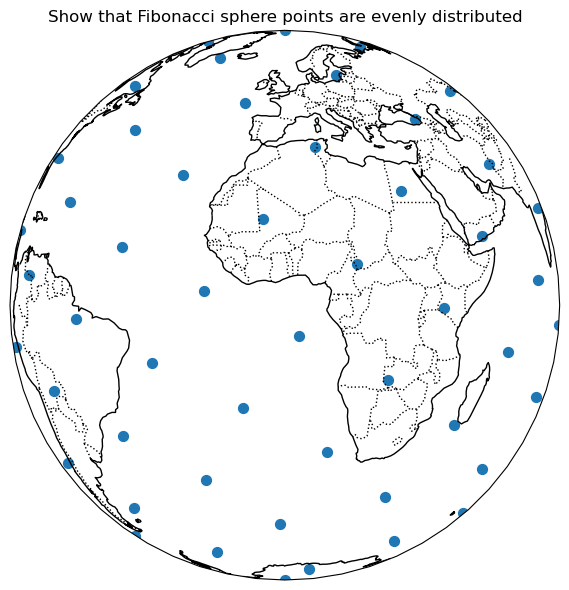

In [4]:
# Create a figure with Mollweide projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Orthographic())

# Add coastlines and other features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data points, using PlateCarree() to convert lat/lon coordinates.
sc = ax.scatter(lons, lats, s=50,
                transform=ccrs.PlateCarree())

ax.set_title("Show that Fibonacci sphere points are evenly distributed")
plt.tight_layout()
plt.show()

In [5]:
num_points = 10000  # number of evenly distributed points
points = generate_fibonacci_sphere_points(num_points)
dec_year = today_decimal_year()

# Create input_list in the format [Date, Altitude, Latitude, Longitude]
# Altitude is set to 0 for all points, and date remains as a float.
input_list_10000 = [[round(2000, 4), 0, lat, lon] for lon, lat in points]

In [6]:
IGRF_VADM = []
longitude_list = []
latitude_list = []

for pt in input_list:
    # ipmag.igrf expects the list in the order: [date, altitude, latitude, longitude]
    igrf_field = ipmag.igrf(pt)
    intensity = igrf_field[2]
    igrf_field_T = intensity/10**9
    latitude = pt[2]
    longitude = pt[3]
    vadm = pmag.b_vdm(igrf_field_T,latitude)/10**21
    IGRF_VADM.append(vadm)
    longitude_list.append(longitude)
    latitude_list.append(latitude) 

NameError: name 'input_list' is not defined

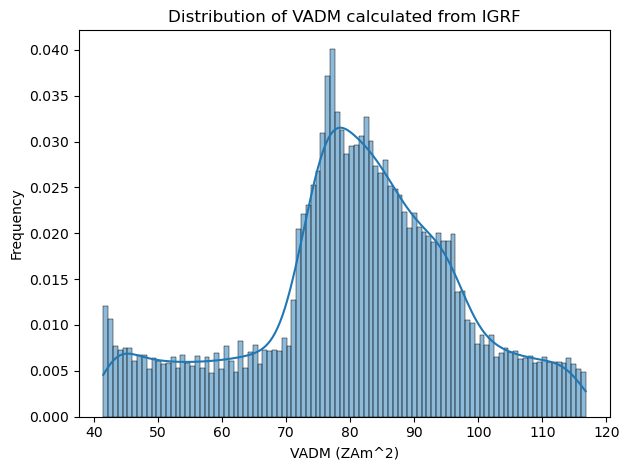

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution with both histogram and KDE overlay
sns.histplot(IGRF_VADM, bins=100, stat="density", edgecolor="black", kde=True)

plt.xlabel("VADM (ZAm^2)")
plt.ylabel("Frequency")
plt.title("Distribution of VADM calculated from IGRF")
plt.tight_layout()
plt.show()

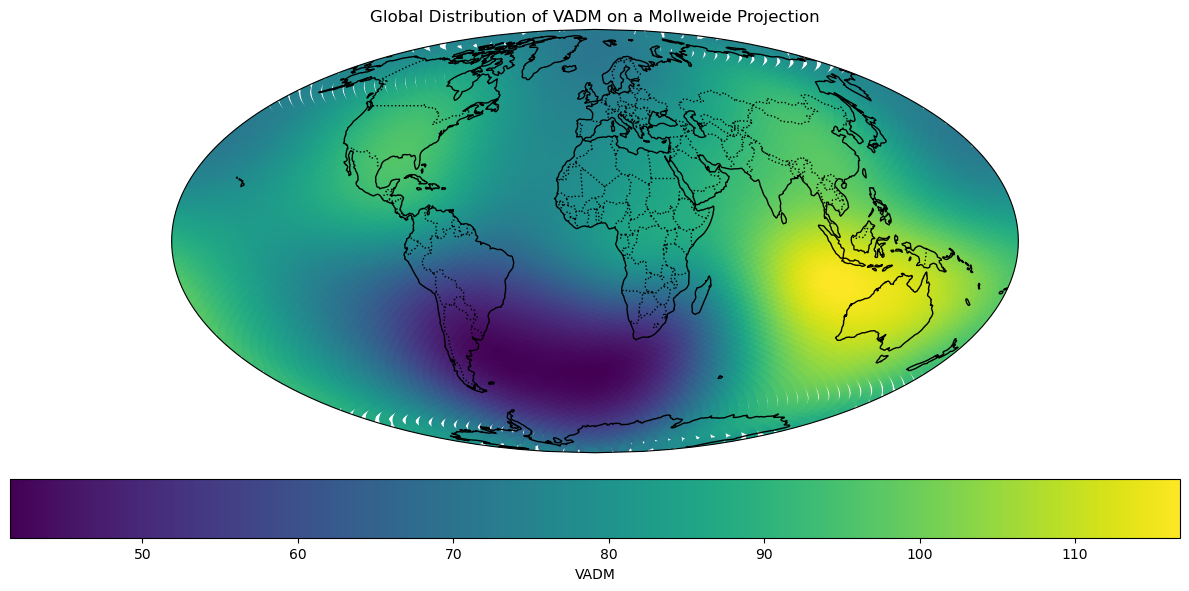

In [ ]:
# Create a figure with Mollweide projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mollweide())

# Add coastlines and other features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data points, using PlateCarree() to convert lat/lon coordinates.
sc = ax.scatter(longitude_list, latitude_list, c=IGRF_VADM, cmap='viridis', s=50, edgecolor='none',
                transform=ccrs.PlateCarree())

# Add a colorbar and labels
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cbar.set_label('VADM')

ax.set_title("Global Distribution of VADM on a Mollweide Projection")
plt.tight_layout()
plt.show()